### Imports

In [1]:
import numpy as np
from sklearn.cluster import KMeans
from tqdm import tqdm
from pprint import pprint
import matplotlib.pyplot as plt
np.random.seed(0)
from scipy import misc
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import cv2
import pandas as pd

### Computation of gamma for each step with the new values (p,m,s)  (E - step )

In [2]:
def gamma_computation(x, m_k, s_k, p_k):
    N = x.shape[0]
    K = p_k.shape[0]

    # at every step of the algorithm gamma is recomputed through the new values of p_k, m_k, s_k
    # at the first step we compute it with the randomly initialized p_k, m_k, s_k
    gammas = np.zeros(( N , K ))
    for k in range(K):
        a = 1 / np.sqrt(2 * np.pi * s_k[k])
        b = np.exp(-np.power((x - m_k[k]), 2) / (2 * s_k[k]))
        gammas[:, k] = p_k[k] * np.prod(a * b, axis=1)

    gamma_sum = np.sum(gammas, axis=1)
    
    for k in range(K):
        gammas[:, k] = gammas[:, k] / gamma_sum

    return gammas , gamma_sum


### Error in order to reconstruct the segmented image

In [3]:
def get_reconstruction_error(initial_image, reconstructed_img):
    error = np.sum((np.linalg.norm(initial_image - reconstructed_img, axis=1) ** 2)) / initial_image.shape[0]
    return error

### Log likelihood computations

In [4]:
def compute_log_likelihood(p_x):
    return np.sum(np.log(p_x))

In [5]:
def compute_log_likelihood_withExptrick(f_s, m):
    likelihood = np.log(np.sum(np.exp(f_s - m[:, np.newaxis]), axis=1))
    return np.sum(m + likelihood, axis=0)

In [6]:
#this will be used in logsumexp trick
def calculate_f_s(X, p_k, m_k, s_k):
    K = s_k.shape[0]

    
    f_s = np.zeros((X.shape[0], K))
    for k in range(K):
        m = m_k[k, :]
        tmp = np.sum(((X - m)**2 / s_k[k]) + np.log(2*np.pi*s_k[k]), axis=1)
        f_s[:, k] = np.log(p_k[k]) - (tmp / 2)

    m = f_s.max(axis=1)
    return f_s, m


### Trainning(EM algorithm)

In [7]:
def train(X, k, iterations):
    N = X.shape[0]
    D = X.shape[1]

    # initialize parameters to random values
    m_k, s_k, p_k = initialize_parameters(k, D)
    tolerance = 1e-6

    
    loss_old = -np.Inf
    gammas = None

    
    for _ in tqdm(range(iterations)):

        # E step
        gammas, _ = gamma_computation(X, m_k, s_k, p_k)

        # M step
        # update the parameters / at the first iteration we update with the random gammas (from the random m_k, s_k, p_k)
        m_k, s_k, p_k = update_parameters(gammas, X)

        # # calculate the new loss with the updated parameters
        f, m = calculate_f_s(X, p_k, m_k, s_k)
        loss_new = compute_log_likelihood_withExptrick(f, m)

        if loss_new - loss_old < 0:
            print('ERROR!!!')
            print('Loss : {}'.format(loss_new))
            exit(0)

        if np.abs(loss_new - loss_old) < tolerance:
            print('Tolerance reached')
            print('Loss : {}'.format(loss_new))
            print(np.sum(p_k))
            return gammas, m_k

        print('Loss : {}'.format(loss_new))
        loss_old = loss_new

    print('All the iterations have been completed')
    
    return gammas, m_k


### Parameter initialization 

In [8]:
def initialize_parameters(k, d):

    # initialize the means m_k with random values 
    m_k = np.random.uniform(0.1, 0.9, (k, d))

    # initialize the variance with random values 
    s_k = np.random.uniform(0.1, 0.9, k)

    # initialize the mixing coefficients p_k
    # filling the array with numbers = 1/k, so the sum will be 1.
    p_k = np.full(k, 1/k)

    return m_k, s_k, p_k


Update mean ( it is used in parameter update )

In [9]:
def update_mean(gammas,X,K,D,N_k):
    m_k_new = np.zeros((K, D))
    for k in range(K):
        # for the new m_k (means)
        gamma_k = gammas[:, k]
        # print(gamma_k.shape)
        for d in range(D):
            m_k_new[k, d] = np.sum(gamma_k * X[:, d], axis=0) / N_k[k]
    return m_k_new

Update s ( it is used in parameter update )

In [10]:
def update_s(gammas,X,mean,K,D,N_k):
    s_k_new = np.zeros(K)
    for k in range(K):
        # for the new m_k (means)
        gamma_k = gammas[:, k]
        tmp = np.power((X - mean[k, :]), 2)
        tmp = np.sum(tmp, axis=1)
        s_k_new[k] = np.sum(tmp * gamma_k, axis=0) / (N_k[k] * D)
        
    return s_k_new

Update p ( it is used in parameter update )

In [11]:
def update_p(N_k,N,K):
    p_k_new = np.zeros(K)
    for k in range(K):
        p_k_new[k] = N_k[k] / N  
    return p_k_new

### Parameter update ( M step of the algorithm)

In [12]:
def update_parameters(gammas, X):
    N = X.shape[0]
    D = X.shape[1]
    K = gammas.shape[1]
   
    
    N_k = np.sum(gammas, axis=0)

    m_k_new =  update_mean(gammas,X,K,D,N_k)
    s_k_new =  update_s(gammas,X,m_k_new,K,D,N_k)
    p_k_new =  update_p(N_k,N,K)

    return m_k_new, s_k_new, p_k_new


### Fitting the image 

In [18]:
def fit(k, X):
    # trainning for the specific K 
    gammas, m_k = train(X, k, iterations=100)
    #
    reconstructed_img = np.zeros(X.shape)
    # for each pixel
    for i in range(X.shape[0]):
        # the category of each pixel will be the bigger value of gammas 
        idx = gammas[i].argmax()
        # the correspoding to gammas mean, the mean contains 3 values each of them represent the R,G,B values 
        reconstructed_img[i] = m_k[idx]

    initial_image = X
    error = get_reconstruction_error(initial_image, reconstructed_img)
    print('{} : The error is : {}'.format(k, error))

    # reshape the image to its original shape
    segmented_image = reconstructed_img.reshape(h, w, dimensions)
    plt.imshow(segmented_image)
    plt.savefig(r"results\segmented_im_{}.jpg".format(k))
    plt.show()
    plt.close()
    #C:\Users\giann\Desktop\Εργασια2\

### Image preparation and visualization 

For test reasons the image with the child from the slides has been also used

In [14]:
#C:\Users\giann\Desktop\Εργασια2\
image = misc.imread(r'images\im.jpg')
h = image.shape[0]
w = image.shape[1]
dimensions = image.shape[2]
pixels = h * w



D:\Anaconda\lib\site-packages\ipykernel_launcher.py:1: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  """Entry point for launching an IPython kernel.


Initial Image

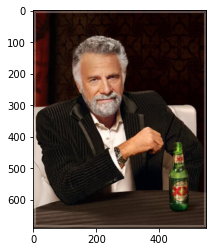

In [15]:
plt.imshow(image)
plt.show()

In [16]:
data = image.reshape(pixels, dimensions)
# normalize the data
data = data / 255

Segmenting the image.

  0%|          | 0/100 [00:00<?, ?it/s]

K :  1


  1%|          | 1/100 [00:00<00:26,  3.76it/s]

Loss : 2958.8593638632906


  1%|          | 1/100 [00:00<00:51,  1.91it/s]

Tolerance reached
Loss : 2958.8593638632906
1.0


1 : The error is : 0.17473886870077288


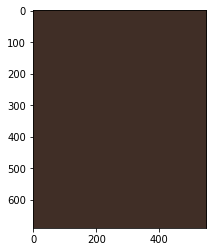

  0%|          | 0/100 [00:00<?, ?it/s]

-------------
K :  2


  1%|          | 1/100 [00:00<00:58,  1.68it/s]

Loss : 99014.06503867058


  2%|▏         | 2/100 [00:01<00:58,  1.67it/s]

Loss : 745527.5588248543


  3%|▎         | 3/100 [00:01<00:56,  1.73it/s]

Loss : 1059562.481536652


  4%|▍         | 4/100 [00:02<00:55,  1.72it/s]

Loss : 1075506.994704415


  5%|▌         | 5/100 [00:02<00:54,  1.73it/s]

Loss : 1080326.3991458165


  6%|▌         | 6/100 [00:03<00:54,  1.73it/s]

Loss : 1082070.7475593567


  7%|▋         | 7/100 [00:04<00:53,  1.74it/s]

Loss : 1082709.0789378427


  8%|▊         | 8/100 [00:04<00:53,  1.72it/s]

Loss : 1082946.8807019826


  9%|▉         | 9/100 [00:05<00:54,  1.67it/s]

Loss : 1083036.7701888839


 10%|█         | 10/100 [00:05<00:54,  1.64it/s]

Loss : 1083071.1102365516


 11%|█         | 11/100 [00:06<00:54,  1.64it/s]

Loss : 1083084.324617697


 12%|█▏        | 12/100 [00:07<00:54,  1.63it/s]

Loss : 1083089.4341236693


 13%|█▎        | 13/100 [00:07<00:53,  1.63it/s]

Loss : 1083091.4159261056


 14%|█▍        | 14/100 [00:08<00:51,  1.67it/s]

Loss : 1083092.1861249576


 15%|█▌        | 15/100 [00:08<00:51,  1.67it/s]

Loss : 1083092.4858276476


 16%|█▌        | 16/100 [00:09<00:50,  1.66it/s]

Loss : 1083092.6025410523


 17%|█▋        | 17/100 [00:10<00:50,  1.64it/s]

Loss : 1083092.648015546


 18%|█▊        | 18/100 [00:10<00:50,  1.62it/s]

Loss : 1083092.6657389987


 19%|█▉        | 19/100 [00:11<00:48,  1.68it/s]

Loss : 1083092.672647971


 20%|██        | 20/100 [00:11<00:47,  1.69it/s]

Loss : 1083092.675341621


 21%|██        | 21/100 [00:12<00:45,  1.73it/s]

Loss : 1083092.676391838


 22%|██▏       | 22/100 [00:13<00:44,  1.75it/s]

Loss : 1083092.6768012901


 23%|██▎       | 23/100 [00:13<00:45,  1.69it/s]

Loss : 1083092.676961085


 24%|██▍       | 24/100 [00:14<00:45,  1.66it/s]

Loss : 1083092.6770232387


 25%|██▌       | 25/100 [00:14<00:46,  1.63it/s]

Loss : 1083092.677047567


 26%|██▌       | 26/100 [00:15<00:46,  1.58it/s]

Loss : 1083092.67705704


 27%|██▋       | 27/100 [00:16<00:45,  1.59it/s]

Loss : 1083092.6770607587


 28%|██▊       | 28/100 [00:16<00:45,  1.59it/s]

Loss : 1083092.677062254


 28%|██▊       | 28/100 [00:17<00:45,  1.60it/s]

Tolerance reached
Loss : 1083092.677062656
0.9999999999998188


2 : The error is : 0.048832469138688536


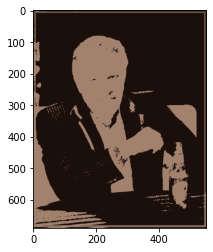

  0%|          | 0/100 [00:00<?, ?it/s]

-------------
K :  4


  1%|          | 1/100 [00:01<02:02,  1.23s/it]

Loss : 179383.7291165694


  2%|▏         | 2/100 [00:02<02:04,  1.27s/it]

Loss : 814548.7392900885


  3%|▎         | 3/100 [00:03<02:04,  1.28s/it]

Loss : 1021624.1497402515


  4%|▍         | 4/100 [00:05<02:04,  1.30s/it]

Loss : 1074398.2796438723


  5%|▌         | 5/100 [00:06<02:02,  1.29s/it]

Loss : 1184251.9123060852


  6%|▌         | 6/100 [00:07<02:00,  1.28s/it]

Loss : 1319119.4849377328


  7%|▋         | 7/100 [00:09<02:00,  1.29s/it]

Loss : 1354456.5627042612


  8%|▊         | 8/100 [00:10<02:01,  1.32s/it]

Loss : 1356068.212790488


  9%|▉         | 9/100 [00:11<01:57,  1.29s/it]

Loss : 1358036.948687066


 10%|█         | 10/100 [00:12<01:54,  1.28s/it]

Loss : 1365124.328537949


 11%|█         | 11/100 [00:14<01:51,  1.26s/it]

Loss : 1387250.6597074424


 12%|█▏        | 12/100 [00:15<01:50,  1.26s/it]

Loss : 1424741.8220536492


 13%|█▎        | 13/100 [00:16<01:54,  1.32s/it]

Loss : 1447743.1335285942


 14%|█▍        | 14/100 [00:18<01:51,  1.30s/it]

Loss : 1453924.603125761


 15%|█▌        | 15/100 [00:19<01:47,  1.27s/it]

Loss : 1456485.4712147743


 16%|█▌        | 16/100 [00:20<01:45,  1.25s/it]

Loss : 1458161.031129046


 17%|█▋        | 17/100 [00:21<01:44,  1.25s/it]

Loss : 1459358.5532434667


 18%|█▊        | 18/100 [00:22<01:40,  1.23s/it]

Loss : 1460251.2194377137


 19%|█▉        | 19/100 [00:24<01:39,  1.22s/it]

Loss : 1460942.2609113841


 20%|██        | 20/100 [00:25<01:35,  1.20s/it]

Loss : 1461495.3753959576


 21%|██        | 21/100 [00:26<01:33,  1.18s/it]

Loss : 1461950.4067975772


 22%|██▏       | 22/100 [00:27<01:31,  1.18s/it]

Loss : 1462332.8698292652


 23%|██▎       | 23/100 [00:28<01:31,  1.19s/it]

Loss : 1462659.649455447


 24%|██▍       | 24/100 [00:29<01:28,  1.16s/it]

Loss : 1462942.351575003


 25%|██▌       | 25/100 [00:30<01:24,  1.13s/it]

Loss : 1463189.2690070372


 26%|██▌       | 26/100 [00:32<01:24,  1.14s/it]

Loss : 1463406.5475996297


 27%|██▋       | 27/100 [00:33<01:22,  1.13s/it]

Loss : 1463598.8916851215


 28%|██▊       | 28/100 [00:34<01:23,  1.16s/it]

Loss : 1463770.002033648


 29%|██▉       | 29/100 [00:35<01:22,  1.17s/it]

Loss : 1463922.8560067005


 30%|███       | 30/100 [00:36<01:24,  1.21s/it]

Loss : 1464059.892652497


 31%|███       | 31/100 [00:38<01:24,  1.23s/it]

Loss : 1464183.1391066243


 32%|███▏      | 32/100 [00:39<01:23,  1.22s/it]

Loss : 1464294.2997451092


 33%|███▎      | 33/100 [00:40<01:21,  1.22s/it]

Loss : 1464394.8209969664


 34%|███▍      | 34/100 [00:41<01:19,  1.20s/it]

Loss : 1464485.9397743805


 35%|███▌      | 35/100 [00:42<01:16,  1.18s/it]

Loss : 1464568.7205390367


 36%|███▌      | 36/100 [00:44<01:16,  1.20s/it]

Loss : 1464644.0842651355


 37%|███▋      | 37/100 [00:45<01:14,  1.18s/it]

Loss : 1464712.8314663942


 38%|███▊      | 38/100 [00:46<01:13,  1.19s/it]

Loss : 1464775.6607731348


 39%|███▉      | 39/100 [00:47<01:13,  1.20s/it]

Loss : 1464833.1841015576


 40%|████      | 40/100 [00:48<01:10,  1.18s/it]

Loss : 1464885.939166225


 41%|████      | 41/100 [00:50<01:08,  1.16s/it]

Loss : 1464934.3998900442


 42%|████▏     | 42/100 [00:51<01:06,  1.15s/it]

Loss : 1464978.9851261636


 43%|████▎     | 43/100 [00:52<01:05,  1.16s/it]

Loss : 1465020.0660122077


 44%|████▍     | 44/100 [00:53<01:07,  1.21s/it]

Loss : 1465057.9722026906


 45%|████▌     | 45/100 [00:54<01:06,  1.20s/it]

Loss : 1465092.9971783634


 46%|████▌     | 46/100 [00:55<01:04,  1.19s/it]

Loss : 1465125.4027845296


 47%|████▋     | 47/100 [00:57<01:00,  1.15s/it]

Loss : 1465155.4231275793


 48%|████▊     | 48/100 [00:58<00:58,  1.13s/it]

Loss : 1465183.2679309414


 49%|████▉     | 49/100 [00:59<00:56,  1.11s/it]

Loss : 1465209.1254342129


 50%|█████     | 50/100 [01:00<00:56,  1.14s/it]

Loss : 1465233.1649045697


 51%|█████     | 51/100 [01:01<00:58,  1.20s/it]

Loss : 1465255.5388198688


 52%|█████▏    | 52/100 [01:02<00:58,  1.21s/it]

Loss : 1465276.3847684725


 53%|█████▎    | 53/100 [01:04<00:56,  1.19s/it]

Loss : 1465295.8271091015


 54%|█████▍    | 54/100 [01:05<00:55,  1.21s/it]

Loss : 1465313.9784222587


 55%|█████▌    | 55/100 [01:06<00:53,  1.19s/it]

Loss : 1465330.940783935


 56%|█████▌    | 56/100 [01:07<00:52,  1.19s/it]

Loss : 1465346.806883789


 57%|█████▋    | 57/100 [01:09<00:53,  1.24s/it]

Loss : 1465361.661010529


 58%|█████▊    | 58/100 [01:10<00:53,  1.27s/it]

Loss : 1465375.579920882


 59%|█████▉    | 59/100 [01:11<00:52,  1.27s/it]

Loss : 1465388.6336077724


 60%|██████    | 60/100 [01:12<00:49,  1.23s/it]

Loss : 1465400.8859800168


 61%|██████    | 61/100 [01:13<00:46,  1.20s/it]

Loss : 1465412.3954661302


 62%|██████▏   | 62/100 [01:14<00:43,  1.15s/it]

Loss : 1465423.2155500914


 63%|██████▎   | 63/100 [01:16<00:42,  1.14s/it]

Loss : 1465433.3952486066


 64%|██████▍   | 64/100 [01:17<00:40,  1.14s/it]

Loss : 1465442.9795363962


 65%|██████▌   | 65/100 [01:18<00:41,  1.17s/it]

Loss : 1465452.0097263737


 66%|██████▌   | 66/100 [01:19<00:39,  1.17s/it]

Loss : 1465460.5238088826


 67%|██████▋   | 67/100 [01:20<00:38,  1.16s/it]

Loss : 1465468.556756443


 68%|██████▊   | 68/100 [01:21<00:37,  1.16s/it]

Loss : 1465476.1407968046


 69%|██████▉   | 69/100 [01:23<00:35,  1.15s/it]

Loss : 1465483.3056575372


 70%|███████   | 70/100 [01:24<00:34,  1.15s/it]

Loss : 1465490.0787874954


 71%|███████   | 71/100 [01:25<00:33,  1.17s/it]

Loss : 1465496.4855550425


 72%|███████▏  | 72/100 [01:26<00:33,  1.18s/it]

Loss : 1465502.5494276742


 73%|███████▎  | 73/100 [01:27<00:31,  1.15s/it]

Loss : 1465508.2921336289


 74%|███████▍  | 74/100 [01:28<00:30,  1.17s/it]

Loss : 1465513.7338085647


 75%|███████▌  | 75/100 [01:30<00:28,  1.15s/it]

Loss : 1465518.8931283008


 76%|███████▌  | 76/100 [01:31<00:27,  1.16s/it]

Loss : 1465523.7874287353


 77%|███████▋  | 77/100 [01:32<00:26,  1.14s/it]

Loss : 1465528.432815131


 78%|███████▊  | 78/100 [01:33<00:24,  1.12s/it]

Loss : 1465532.8442614637


 79%|███████▉  | 79/100 [01:34<00:22,  1.09s/it]

Loss : 1465537.0357005468


 80%|████████  | 80/100 [01:35<00:21,  1.08s/it]

Loss : 1465541.0201057666


 81%|████████  | 81/100 [01:36<00:20,  1.09s/it]

Loss : 1465544.8095667444


 82%|████████▏ | 82/100 [01:37<00:19,  1.09s/it]

Loss : 1465548.415357111


 83%|████████▎ | 83/100 [01:38<00:18,  1.12s/it]

Loss : 1465551.8479972987


 84%|████████▍ | 84/100 [01:40<00:18,  1.16s/it]

Loss : 1465555.1173110812


 85%|████████▌ | 85/100 [01:41<00:18,  1.21s/it]

Loss : 1465558.232478561


 86%|████████▌ | 86/100 [01:42<00:17,  1.28s/it]

Loss : 1465561.20208348


 87%|████████▋ | 87/100 [01:44<00:16,  1.27s/it]

Loss : 1465564.0341575304


 88%|████████▊ | 88/100 [01:45<00:14,  1.21s/it]

Loss : 1465566.7362201614


 89%|████████▉ | 89/100 [01:46<00:13,  1.19s/it]

Loss : 1465569.3153160876


 90%|█████████ | 90/100 [01:47<00:11,  1.18s/it]

Loss : 1465571.7780486448


 91%|█████████ | 91/100 [01:48<00:10,  1.16s/it]

Loss : 1465574.130611916


 92%|█████████▏| 92/100 [01:49<00:09,  1.17s/it]

Loss : 1465576.378818808


 93%|█████████▎| 93/100 [01:51<00:08,  1.18s/it]

Loss : 1465578.5281280163


 94%|█████████▍| 94/100 [01:52<00:06,  1.14s/it]

Loss : 1465580.5836684096


 95%|█████████▌| 95/100 [01:53<00:05,  1.15s/it]

Loss : 1465582.5502611944


 96%|█████████▌| 96/100 [01:54<00:04,  1.17s/it]

Loss : 1465584.4324417775


 97%|█████████▋| 97/100 [01:55<00:03,  1.19s/it]

Loss : 1465586.234477992


 98%|█████████▊| 98/100 [01:56<00:02,  1.19s/it]

Loss : 1465587.9603886348


 99%|█████████▉| 99/100 [01:58<00:01,  1.20s/it]

Loss : 1465589.6139594144


100%|██████████| 100/100 [01:59<00:00,  1.19s/it]

Loss : 1465591.1987588967
All the iterations have been completed


4 : The error is : 0.02045119904491206


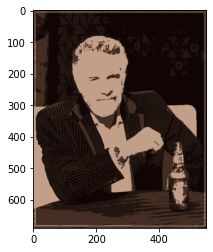

  0%|          | 0/100 [00:00<?, ?it/s]

-------------
K :  8


  1%|          | 1/100 [00:02<03:44,  2.27s/it]

Loss : 401324.0346487536


  2%|▏         | 2/100 [00:04<03:41,  2.26s/it]

Loss : 1062412.8752036034


  3%|▎         | 3/100 [00:06<03:37,  2.24s/it]

Loss : 1278519.3646728352


  4%|▍         | 4/100 [00:09<03:38,  2.28s/it]

Loss : 1428180.3629653037


  5%|▌         | 5/100 [00:11<03:46,  2.38s/it]

Loss : 1501439.4084960187


  6%|▌         | 6/100 [00:14<03:52,  2.48s/it]

Loss : 1524200.6623348824


  7%|▋         | 7/100 [00:16<03:49,  2.47s/it]

Loss : 1539640.8351613143


  8%|▊         | 8/100 [00:19<03:47,  2.47s/it]

Loss : 1548771.0005879113


  9%|▉         | 9/100 [00:21<03:47,  2.50s/it]

Loss : 1554057.4145298116


 10%|█         | 10/100 [00:24<03:48,  2.54s/it]

Loss : 1557601.7760952238


 11%|█         | 11/100 [00:27<03:45,  2.53s/it]

Loss : 1560302.6217069828


 12%|█▏        | 12/100 [00:29<03:42,  2.53s/it]

Loss : 1562639.1037003251


 13%|█▎        | 13/100 [00:32<03:39,  2.52s/it]

Loss : 1564940.3730213037


 14%|█▍        | 14/100 [00:34<03:37,  2.53s/it]

Loss : 1567538.287152248


 15%|█▌        | 15/100 [00:37<03:34,  2.52s/it]

Loss : 1570859.6241462126


 16%|█▌        | 16/100 [00:39<03:31,  2.52s/it]

Loss : 1575461.7911554538


 17%|█▋        | 17/100 [00:42<03:31,  2.55s/it]

Loss : 1581849.590771857


 18%|█▊        | 18/100 [00:44<03:29,  2.56s/it]

Loss : 1589871.6204859193


 19%|█▉        | 19/100 [00:47<03:37,  2.68s/it]

Loss : 1598276.2206460147


 20%|██        | 20/100 [00:50<03:31,  2.65s/it]

Loss : 1605847.845460433


 21%|██        | 21/100 [00:52<03:28,  2.64s/it]

Loss : 1612125.3416205717


 22%|██▏       | 22/100 [00:55<03:27,  2.66s/it]

Loss : 1617148.5603226027


 23%|██▎       | 23/100 [00:58<03:21,  2.62s/it]

Loss : 1621170.2420853707


 24%|██▍       | 24/100 [01:01<03:24,  2.69s/it]

Loss : 1624428.6492752642


 25%|██▌       | 25/100 [01:03<03:15,  2.61s/it]

Loss : 1627102.7128234452


 26%|██▌       | 26/100 [01:05<03:05,  2.51s/it]

Loss : 1629327.552847368


 27%|██▋       | 27/100 [01:08<03:02,  2.51s/it]

Loss : 1631203.6343192854


 28%|██▊       | 28/100 [01:10<02:59,  2.49s/it]

Loss : 1632800.8839980944


 29%|██▉       | 29/100 [01:13<02:54,  2.46s/it]

Loss : 1634165.1227300728


 30%|███       | 30/100 [01:15<02:47,  2.39s/it]

Loss : 1635327.04415851


 31%|███       | 31/100 [01:17<02:45,  2.40s/it]

Loss : 1636310.7063328738


 32%|███▏      | 32/100 [01:19<02:36,  2.30s/it]

Loss : 1637138.7536296109


 33%|███▎      | 33/100 [01:21<02:31,  2.26s/it]

Loss : 1637833.971125639


 34%|███▍      | 34/100 [01:24<02:26,  2.22s/it]

Loss : 1638418.616746427


 35%|███▌      | 35/100 [01:26<02:25,  2.23s/it]

Loss : 1638913.2675148933


 36%|███▌      | 36/100 [01:28<02:21,  2.22s/it]

Loss : 1639336.071920377


 37%|███▋      | 37/100 [01:30<02:21,  2.25s/it]

Loss : 1639702.5472563626


 38%|███▊      | 38/100 [01:33<02:26,  2.36s/it]

Loss : 1640025.759591758


 39%|███▉      | 39/100 [01:35<02:24,  2.37s/it]

Loss : 1640316.6929595342


 40%|████      | 40/100 [01:38<02:19,  2.33s/it]

Loss : 1640584.6739549476


 41%|████      | 41/100 [01:40<02:16,  2.31s/it]

Loss : 1640837.7573295326


 42%|████▏     | 42/100 [01:42<02:12,  2.28s/it]

Loss : 1641082.971685566


 43%|████▎     | 43/100 [01:45<02:13,  2.34s/it]

Loss : 1641326.3546011546


 44%|████▍     | 44/100 [01:47<02:11,  2.34s/it]

Loss : 1641572.87065473


 45%|████▌     | 45/100 [01:50<02:12,  2.41s/it]

Loss : 1641826.5108011223


 46%|████▌     | 46/100 [01:52<02:13,  2.46s/it]

Loss : 1642090.7032517847


 47%|████▋     | 47/100 [01:55<02:12,  2.50s/it]

Loss : 1642368.598227142


 48%|████▊     | 48/100 [01:57<02:09,  2.49s/it]

Loss : 1642662.9139498747


 49%|████▉     | 49/100 [02:00<02:06,  2.47s/it]

Loss : 1642975.771354094


 50%|█████     | 50/100 [02:02<02:02,  2.45s/it]

Loss : 1643308.749491947


 51%|█████     | 51/100 [02:04<01:59,  2.45s/it]

Loss : 1643662.5743657078


 52%|█████▏    | 52/100 [02:07<01:58,  2.47s/it]

Loss : 1644036.2335952146


 53%|█████▎    | 53/100 [02:09<01:55,  2.46s/it]

Loss : 1644426.081669952


 54%|█████▍    | 54/100 [02:12<01:54,  2.49s/it]

Loss : 1644825.1427483635


 55%|█████▌    | 55/100 [02:14<01:52,  2.49s/it]

Loss : 1645223.9799412708


 56%|█████▌    | 56/100 [02:17<01:47,  2.44s/it]

Loss : 1645613.2412045144


 57%|█████▋    | 57/100 [02:19<01:46,  2.47s/it]

Loss : 1645985.4734606135


 58%|█████▊    | 58/100 [02:22<01:45,  2.52s/it]

Loss : 1646335.7301109321


 59%|█████▉    | 59/100 [02:24<01:42,  2.49s/it]

Loss : 1646661.339957656


 60%|██████    | 60/100 [02:27<01:38,  2.47s/it]

Loss : 1646960.771307902


 61%|██████    | 61/100 [02:29<01:36,  2.46s/it]

Loss : 1647232.916298313


 62%|██████▏   | 62/100 [02:32<01:33,  2.47s/it]

Loss : 1647477.3409251862


 63%|██████▎   | 63/100 [02:34<01:31,  2.48s/it]

Loss : 1647694.6069217203


 64%|██████▍   | 64/100 [02:37<01:31,  2.54s/it]

Loss : 1647886.2122905303


 65%|██████▌   | 65/100 [02:39<01:29,  2.55s/it]

Loss : 1648054.3478292702


 66%|██████▌   | 66/100 [02:42<01:26,  2.53s/it]

Loss : 1648201.6332597518


 67%|██████▋   | 67/100 [02:44<01:23,  2.52s/it]

Loss : 1648330.8445743292


 68%|██████▊   | 68/100 [02:47<01:20,  2.52s/it]

Loss : 1648444.6643534547


 69%|██████▉   | 69/100 [02:50<01:18,  2.54s/it]

Loss : 1648545.5118152844


 70%|███████   | 70/100 [02:52<01:15,  2.51s/it]

Loss : 1648635.4669594204


 71%|███████   | 71/100 [02:54<01:12,  2.51s/it]

Loss : 1648716.2629531103


 72%|███████▏  | 72/100 [02:57<01:09,  2.47s/it]

Loss : 1648789.3140097295


 73%|███████▎  | 73/100 [02:59<01:04,  2.41s/it]

Loss : 1648855.756280448


 74%|███████▍  | 74/100 [03:01<01:01,  2.38s/it]

Loss : 1648916.4904353213


 75%|███████▌  | 75/100 [03:04<00:58,  2.33s/it]

Loss : 1648972.221601775


 76%|███████▌  | 76/100 [03:06<00:54,  2.29s/it]

Loss : 1649023.4956511355


 77%|███████▋  | 77/100 [03:08<00:52,  2.27s/it]

Loss : 1649070.731981985


 78%|███████▊  | 78/100 [03:10<00:50,  2.31s/it]

Loss : 1649114.2530665633


 79%|███████▉  | 79/100 [03:13<00:48,  2.30s/it]

Loss : 1649154.3107697766


 80%|████████  | 80/100 [03:15<00:45,  2.30s/it]

Loss : 1649191.1091586603


 81%|████████  | 81/100 [03:17<00:44,  2.34s/it]

Loss : 1649224.8233855944


 82%|████████▏ | 82/100 [03:20<00:40,  2.27s/it]

Loss : 1649255.6142925979


 83%|████████▎ | 83/100 [03:22<00:39,  2.31s/it]

Loss : 1649283.6386379432


 84%|████████▍ | 84/100 [03:24<00:37,  2.33s/it]

Loss : 1649309.0552015405


 85%|████████▌ | 85/100 [03:27<00:34,  2.32s/it]

Loss : 1649332.027363749


 86%|████████▌ | 86/100 [03:29<00:32,  2.31s/it]

Loss : 1649352.7230000866


 87%|████████▋ | 87/100 [03:31<00:29,  2.29s/it]

Loss : 1649371.3126156195


 88%|████████▊ | 88/100 [03:33<00:27,  2.26s/it]

Loss : 1649387.9665829507


 89%|████████▉ | 89/100 [03:36<00:24,  2.24s/it]

Loss : 1649402.8521762055


 90%|█████████ | 90/100 [03:38<00:22,  2.27s/it]

Loss : 1649416.1308759782


 91%|█████████ | 91/100 [03:40<00:20,  2.29s/it]

Loss : 1649427.956212288


 92%|█████████▏| 92/100 [03:43<00:18,  2.31s/it]

Loss : 1649438.4722417274


 93%|█████████▎| 93/100 [03:45<00:16,  2.29s/it]

Loss : 1649447.8126374064


 94%|█████████▍| 94/100 [03:47<00:13,  2.31s/it]

Loss : 1649456.1003055603


 95%|█████████▌| 95/100 [03:49<00:11,  2.27s/it]

Loss : 1649463.4474168092


 96%|█████████▌| 96/100 [03:52<00:09,  2.27s/it]

Loss : 1649469.9557361444


 97%|█████████▋| 97/100 [03:54<00:06,  2.29s/it]

Loss : 1649475.7171525257


 98%|█████████▊| 98/100 [03:56<00:04,  2.31s/it]

Loss : 1649480.8143288745


 99%|█████████▉| 99/100 [03:59<00:02,  2.36s/it]

Loss : 1649485.321408016


100%|██████████| 100/100 [04:01<00:00,  2.42s/it]

Loss : 1649489.304735443
All the iterations have been completed


8 : The error is : 0.006447352073066304


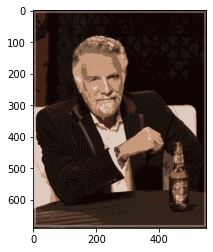

  0%|          | 0/100 [00:00<?, ?it/s]

-------------
K :  16


  1%|          | 1/100 [00:04<07:58,  4.84s/it]

Loss : 191122.63790369683


  2%|▏         | 2/100 [00:09<07:55,  4.85s/it]

Loss : 955691.9585549155


  3%|▎         | 3/100 [00:14<07:47,  4.82s/it]

Loss : 1255729.0244721582


  4%|▍         | 4/100 [00:19<07:54,  4.94s/it]

Loss : 1391071.4105707067


  5%|▌         | 5/100 [00:24<07:53,  4.98s/it]

Loss : 1482875.9732832732


  6%|▌         | 6/100 [00:29<07:41,  4.91s/it]

Loss : 1544825.4454274666


  7%|▋         | 7/100 [00:34<07:29,  4.83s/it]

Loss : 1600121.188745612


  8%|▊         | 8/100 [00:38<07:21,  4.80s/it]

Loss : 1645120.9878211797


  9%|▉         | 9/100 [00:43<07:09,  4.72s/it]

Loss : 1677158.1569821883


 10%|█         | 10/100 [00:47<06:53,  4.59s/it]

Loss : 1703241.947147146


 11%|█         | 11/100 [00:52<06:44,  4.54s/it]

Loss : 1728300.7037954258


 12%|█▏        | 12/100 [00:56<06:30,  4.44s/it]

Loss : 1751326.274551313


 13%|█▎        | 13/100 [01:00<06:30,  4.48s/it]

Loss : 1780178.5422403316


 14%|█▍        | 14/100 [01:05<06:28,  4.52s/it]

Loss : 1816888.220605702


 15%|█▌        | 15/100 [01:10<06:26,  4.55s/it]

Loss : 1851842.1127055888


 16%|█▌        | 16/100 [01:14<06:17,  4.50s/it]

Loss : 1873771.1180506474


 17%|█▋        | 17/100 [01:19<06:16,  4.54s/it]

Loss : 1881692.164389638


 18%|█▊        | 18/100 [01:23<06:09,  4.51s/it]

Loss : 1884975.6217226188


 19%|█▉        | 19/100 [01:28<06:11,  4.59s/it]

Loss : 1887184.8337143648


 20%|██        | 20/100 [01:33<06:14,  4.68s/it]

Loss : 1888964.1686076135


 21%|██        | 21/100 [01:37<06:07,  4.65s/it]

Loss : 1890478.4638025528


 22%|██▏       | 22/100 [01:42<05:59,  4.61s/it]

Loss : 1891793.5081538714


 23%|██▎       | 23/100 [01:47<05:57,  4.64s/it]

Loss : 1892943.2935702805


 24%|██▍       | 24/100 [01:51<05:50,  4.61s/it]

Loss : 1893948.366847017


 25%|██▌       | 25/100 [01:56<05:44,  4.59s/it]

Loss : 1894823.2719638222


 26%|██▌       | 26/100 [02:00<05:38,  4.57s/it]

Loss : 1895581.51452969


 27%|██▋       | 27/100 [02:05<05:39,  4.65s/it]

Loss : 1896237.0665542614


 28%|██▊       | 28/100 [02:10<05:40,  4.72s/it]

Loss : 1896803.155332959


 29%|██▉       | 29/100 [02:15<05:38,  4.77s/it]

Loss : 1897291.5951335651


 30%|███       | 30/100 [02:20<05:36,  4.80s/it]

Loss : 1897713.3238948265


 31%|███       | 31/100 [02:24<05:25,  4.72s/it]

Loss : 1898078.7364691978


 32%|███▏      | 32/100 [02:29<05:18,  4.68s/it]

Loss : 1898397.262887502


 33%|███▎      | 33/100 [02:34<05:18,  4.75s/it]

Loss : 1898676.8176799498


 34%|███▍      | 34/100 [02:39<05:17,  4.80s/it]

Loss : 1898923.6510210263


 35%|███▌      | 35/100 [02:43<05:12,  4.80s/it]

Loss : 1899142.5873166374


 36%|███▌      | 36/100 [02:48<05:06,  4.78s/it]

Loss : 1899337.410409951


 37%|███▋      | 37/100 [02:53<05:01,  4.78s/it]

Loss : 1899511.2048596384


 38%|███▊      | 38/100 [02:58<05:08,  4.98s/it]

Loss : 1899666.5815894103


 39%|███▉      | 39/100 [03:04<05:11,  5.10s/it]

Loss : 1899805.8017743048


 40%|████      | 40/100 [03:09<05:11,  5.19s/it]

Loss : 1899930.8419725923


 41%|████      | 41/100 [03:14<04:59,  5.07s/it]

Loss : 1900043.434610718


 42%|████▏     | 42/100 [03:19<04:58,  5.15s/it]

Loss : 1900145.0997108298


 43%|████▎     | 43/100 [03:24<04:50,  5.09s/it]

Loss : 1900237.172081314


 44%|████▍     | 44/100 [03:29<04:37,  4.96s/it]

Loss : 1900320.8243501983


 45%|████▌     | 45/100 [03:34<04:36,  5.03s/it]

Loss : 1900397.0861285608


 46%|████▌     | 46/100 [03:39<04:36,  5.11s/it]

Loss : 1900466.8601351576


 47%|████▋     | 47/100 [03:45<04:32,  5.15s/it]

Loss : 1900530.9362322695


 48%|████▊     | 48/100 [03:50<04:29,  5.19s/it]

Loss : 1900590.0040722361


 49%|████▉     | 49/100 [03:55<04:18,  5.07s/it]

Loss : 1900644.6647179078


 50%|█████     | 50/100 [04:00<04:10,  5.01s/it]

Loss : 1900695.4413471092


 51%|█████     | 51/100 [04:05<04:06,  5.02s/it]

Loss : 1900742.7890358036


 52%|█████▏    | 52/100 [04:10<04:01,  5.04s/it]

Loss : 1900787.1035872663


 53%|█████▎    | 53/100 [04:15<03:56,  5.04s/it]

Loss : 1900828.7294026248


 54%|█████▍    | 54/100 [04:20<03:50,  5.01s/it]

Loss : 1900867.9664268428


 55%|█████▌    | 55/100 [04:25<03:50,  5.12s/it]

Loss : 1900905.0762316869


 56%|█████▌    | 56/100 [04:30<03:41,  5.04s/it]

Loss : 1900940.287319608


 57%|█████▋    | 57/100 [04:35<03:36,  5.03s/it]

Loss : 1900973.7997346048


 58%|█████▊    | 58/100 [04:40<03:29,  4.98s/it]

Loss : 1901005.789064399


 59%|█████▉    | 59/100 [04:45<03:22,  4.94s/it]

Loss : 1901036.4099109517


 60%|██████    | 60/100 [04:49<03:16,  4.90s/it]

Loss : 1901065.7988965332


 61%|██████    | 61/100 [04:54<03:10,  4.89s/it]

Loss : 1901094.0772646521


 62%|██████▏   | 62/100 [05:00<03:11,  5.05s/it]

Loss : 1901121.3531264416


 63%|██████▎   | 63/100 [05:05<03:05,  5.01s/it]

Loss : 1901147.7233980831


 64%|██████▍   | 64/100 [05:10<03:00,  5.02s/it]

Loss : 1901173.2754674267


 65%|██████▌   | 65/100 [05:15<03:01,  5.18s/it]

Loss : 1901198.0886265552


 66%|██████▌   | 66/100 [05:20<02:53,  5.10s/it]

Loss : 1901222.2353023558


 67%|██████▋   | 67/100 [05:25<02:45,  5.02s/it]

Loss : 1901245.7821139249


 68%|██████▊   | 68/100 [05:30<02:42,  5.08s/it]

Loss : 1901268.7907846388


 69%|██████▉   | 69/100 [05:35<02:33,  4.95s/it]

Loss : 1901291.3189327517


 70%|███████   | 70/100 [05:40<02:29,  4.97s/it]

Loss : 1901313.420764193


 71%|███████   | 71/100 [05:45<02:25,  5.00s/it]

Loss : 1901335.1476872081


 72%|███████▏  | 72/100 [05:51<02:24,  5.17s/it]

Loss : 1901356.5488698524


 73%|███████▎  | 73/100 [05:56<02:24,  5.34s/it]

Loss : 1901377.6717566163


 74%|███████▍  | 74/100 [06:01<02:15,  5.20s/it]

Loss : 1901398.562562823


 75%|███████▌  | 75/100 [06:06<02:08,  5.13s/it]

Loss : 1901419.2667637863


 76%|███████▌  | 76/100 [06:11<01:59,  4.97s/it]

Loss : 1901439.8295958375


 77%|███████▋  | 77/100 [06:15<01:53,  4.92s/it]

Loss : 1901460.2965886188


 78%|███████▊  | 78/100 [06:22<01:57,  5.34s/it]

Loss : 1901480.7141490392


 79%|███████▉  | 79/100 [06:28<01:58,  5.63s/it]

Loss : 1901501.1302209976


 80%|████████  | 80/100 [06:33<01:46,  5.34s/it]

Loss : 1901521.595047489


 81%|████████  | 81/100 [06:38<01:41,  5.37s/it]

Loss : 1901542.162066561


 82%|████████▏ | 82/100 [06:43<01:35,  5.32s/it]

Loss : 1901562.8889779858


 83%|████████▎ | 83/100 [06:49<01:31,  5.40s/it]

Loss : 1901583.8390197137


 84%|████████▍ | 84/100 [06:54<01:25,  5.34s/it]

Loss : 1901605.0824975225


 85%|████████▌ | 85/100 [06:59<01:19,  5.28s/it]

Loss : 1901626.698609072


 86%|████████▌ | 86/100 [07:05<01:13,  5.26s/it]

Loss : 1901648.7775959908


 87%|████████▋ | 87/100 [07:10<01:08,  5.29s/it]

Loss : 1901671.4232374988


 88%|████████▊ | 88/100 [07:15<01:02,  5.21s/it]

Loss : 1901694.7556641153


 89%|████████▉ | 89/100 [07:20<00:56,  5.13s/it]

Loss : 1901718.914413367


 90%|█████████ | 90/100 [07:25<00:50,  5.01s/it]

Loss : 1901744.0615732546


 91%|█████████ | 91/100 [07:29<00:43,  4.85s/it]

Loss : 1901770.3847781552


 92%|█████████▏| 92/100 [07:34<00:38,  4.81s/it]

Loss : 1901798.0997718768


 93%|█████████▎| 93/100 [07:39<00:34,  4.91s/it]

Loss : 1901827.4523057006


 94%|█████████▍| 94/100 [07:44<00:29,  4.90s/it]

Loss : 1901858.719392242


 95%|█████████▌| 95/100 [07:49<00:24,  4.95s/it]

Loss : 1901892.210469523


 96%|█████████▌| 96/100 [07:54<00:19,  4.92s/it]

Loss : 1901928.2698029259


 97%|█████████▋| 97/100 [07:58<00:14,  4.87s/it]

Loss : 1901967.282150427


 98%|█████████▊| 98/100 [08:03<00:09,  4.84s/it]

Loss : 1902009.6836392172


 99%|█████████▉| 99/100 [08:08<00:04,  4.79s/it]

Loss : 1902055.97788399


100%|██████████| 100/100 [08:13<00:00,  4.93s/it]

Loss : 1902106.7525122
All the iterations have been completed


16 : The error is : 0.0051634719447178614


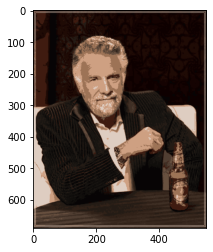

  0%|          | 0/100 [00:00<?, ?it/s]

-------------
K :  32


  1%|          | 1/100 [00:09<14:52,  9.01s/it]

Loss : 420852.9228812603


  2%|▏         | 2/100 [00:18<14:55,  9.14s/it]

Loss : 1098974.4341409972


  3%|▎         | 3/100 [00:27<14:55,  9.23s/it]

Loss : 1318625.6235218477


  4%|▍         | 4/100 [00:37<14:51,  9.29s/it]

Loss : 1453821.6507066016


  5%|▌         | 5/100 [00:47<14:55,  9.42s/it]

Loss : 1531602.9645425112


  6%|▌         | 6/100 [00:56<14:53,  9.51s/it]

Loss : 1585181.1886260754


  7%|▋         | 7/100 [01:06<14:39,  9.45s/it]

Loss : 1646237.319441636


  8%|▊         | 8/100 [01:15<14:40,  9.57s/it]

Loss : 1697704.6136813536


  9%|▉         | 9/100 [01:25<14:28,  9.54s/it]

Loss : 1735291.7211833338


 10%|█         | 10/100 [01:35<14:25,  9.62s/it]

Loss : 1761442.1557479403


 11%|█         | 11/100 [01:44<14:11,  9.57s/it]

Loss : 1781326.217195876


 12%|█▏        | 12/100 [01:54<13:57,  9.51s/it]

Loss : 1798575.3882347287


 13%|█▎        | 13/100 [02:03<13:44,  9.48s/it]

Loss : 1814686.1309212912


 14%|█▍        | 14/100 [02:14<14:14,  9.94s/it]

Loss : 1833328.842066844


 15%|█▌        | 15/100 [02:25<14:29, 10.23s/it]

Loss : 1855550.641966101


 16%|█▌        | 16/100 [02:35<14:04, 10.06s/it]

Loss : 1873110.0037014743


 17%|█▋        | 17/100 [02:44<13:35,  9.83s/it]

Loss : 1884190.7751089372


 18%|█▊        | 18/100 [02:53<13:14,  9.68s/it]

Loss : 1894365.82984614


 19%|█▉        | 19/100 [03:03<12:56,  9.59s/it]

Loss : 1904306.8994178043


 20%|██        | 20/100 [03:12<12:35,  9.44s/it]

Loss : 1912269.539954421


 21%|██        | 21/100 [03:21<12:24,  9.42s/it]

Loss : 1918036.7318216728


 22%|██▏       | 22/100 [03:30<12:15,  9.44s/it]

Loss : 1922119.662915377


 23%|██▎       | 23/100 [03:40<12:00,  9.36s/it]

Loss : 1925100.9336085455


 24%|██▍       | 24/100 [03:49<11:49,  9.33s/it]

Loss : 1927441.387309721


 25%|██▌       | 25/100 [03:58<11:40,  9.34s/it]

Loss : 1929416.0727862446


 26%|██▌       | 26/100 [04:08<11:30,  9.33s/it]

Loss : 1931173.4104522134


 27%|██▋       | 27/100 [04:17<11:27,  9.41s/it]

Loss : 1932794.0362900263


 28%|██▊       | 28/100 [04:27<11:18,  9.42s/it]

Loss : 1934325.914697856


 29%|██▉       | 29/100 [04:36<11:08,  9.42s/it]

Loss : 1935802.0506939453


 30%|███       | 30/100 [04:45<10:57,  9.39s/it]

Loss : 1937248.6653953048


 31%|███       | 31/100 [04:55<10:59,  9.56s/it]

Loss : 1938689.1556094764


 32%|███▏      | 32/100 [05:05<10:54,  9.63s/it]

Loss : 1940146.0479101932


 33%|███▎      | 33/100 [05:15<10:44,  9.62s/it]

Loss : 1941641.8632757156


 34%|███▍      | 34/100 [05:24<10:29,  9.54s/it]

Loss : 1943199.7684281778


 35%|███▌      | 35/100 [05:34<10:20,  9.54s/it]

Loss : 1944844.6778178657


 36%|███▌      | 36/100 [05:43<10:13,  9.59s/it]

Loss : 1946604.6790299676


 37%|███▋      | 37/100 [05:53<10:13,  9.74s/it]

Loss : 1948511.926311695


 38%|███▊      | 38/100 [06:04<10:20, 10.01s/it]

Loss : 1950602.3793857822


 39%|███▉      | 39/100 [06:14<10:06,  9.95s/it]

Loss : 1952915.1874503344


 40%|████      | 40/100 [06:23<09:51,  9.85s/it]

Loss : 1955492.913624685


 41%|████      | 41/100 [06:33<09:37,  9.78s/it]

Loss : 1958380.6288708716


 42%|████▏     | 42/100 [06:43<09:28,  9.79s/it]

Loss : 1961619.2708194943


 43%|████▎     | 43/100 [06:54<09:48, 10.32s/it]

Loss : 1965227.8242784347


 44%|████▍     | 44/100 [07:07<10:09, 10.88s/it]

Loss : 1969163.484155638


 45%|████▌     | 45/100 [07:18<10:05, 11.02s/it]

Loss : 1973275.638830543


 46%|████▌     | 46/100 [07:28<09:35, 10.67s/it]

Loss : 1977320.223918115


 47%|████▋     | 47/100 [07:39<09:28, 10.72s/it]

Loss : 1981043.20878247


 48%|████▊     | 48/100 [07:49<09:10, 10.59s/it]

Loss : 1984284.236283603


 49%|████▉     | 49/100 [08:01<09:21, 11.01s/it]

Loss : 1987025.6200258


 50%|█████     | 50/100 [08:11<08:58, 10.77s/it]

Loss : 1989334.0970702232


 51%|█████     | 51/100 [08:21<08:38, 10.59s/it]

Loss : 1991285.5582389128


 52%|█████▏    | 52/100 [08:32<08:29, 10.61s/it]

Loss : 1992941.545365821


 53%|█████▎    | 53/100 [08:42<08:12, 10.49s/it]

Loss : 1994355.1156641592


 54%|█████▍    | 54/100 [08:52<07:55, 10.33s/it]

Loss : 1995573.7895023387


 55%|█████▌    | 55/100 [09:01<07:30, 10.01s/it]

Loss : 1996636.9851916013


 56%|█████▌    | 56/100 [09:13<07:46, 10.60s/it]

Loss : 1997574.9104513405


 57%|█████▋    | 57/100 [09:26<07:57, 11.10s/it]

Loss : 1998410.167210749


 58%|█████▊    | 58/100 [09:37<07:44, 11.06s/it]

Loss : 1999160.231767957


 59%|█████▉    | 59/100 [09:46<07:13, 10.57s/it]

Loss : 1999839.5150780927


 60%|██████    | 60/100 [09:56<06:56, 10.42s/it]

Loss : 2000460.61786056


 61%|██████    | 61/100 [10:06<06:38, 10.21s/it]

Loss : 2001034.9228776656


 62%|██████▏   | 62/100 [10:15<06:16,  9.91s/it]

Loss : 2001572.9573058472


 63%|██████▎   | 63/100 [10:24<06:00,  9.74s/it]

Loss : 2002084.9555219414


 64%|██████▍   | 64/100 [10:34<05:47,  9.65s/it]

Loss : 2002581.7353687042


 65%|██████▌   | 65/100 [10:44<05:40,  9.72s/it]

Loss : 2003075.7341289192


 66%|██████▌   | 66/100 [10:53<05:29,  9.69s/it]

Loss : 2003582.0346180822


 67%|██████▋   | 67/100 [11:03<05:17,  9.63s/it]

Loss : 2004119.3799237562


 68%|██████▊   | 68/100 [11:13<05:11,  9.74s/it]

Loss : 2004711.3739133612


 69%|██████▉   | 69/100 [11:24<05:11, 10.04s/it]

Loss : 2005387.8280117624


 70%|███████   | 70/100 [11:34<05:07, 10.25s/it]

Loss : 2006185.5499085016


 71%|███████   | 71/100 [11:44<04:51, 10.05s/it]

Loss : 2007147.0401391345


 72%|███████▏  | 72/100 [11:53<04:36,  9.88s/it]

Loss : 2008314.8973003048


 73%|███████▎  | 73/100 [12:03<04:26,  9.85s/it]

Loss : 2009720.7874977156


 74%|███████▍  | 74/100 [12:13<04:15,  9.82s/it]

Loss : 2011371.1797896537


 75%|███████▌  | 75/100 [12:23<04:11, 10.05s/it]

Loss : 2013237.7553028571


 76%|███████▌  | 76/100 [12:34<04:02, 10.09s/it]

Loss : 2015283.689003779


 77%|███████▋  | 77/100 [12:44<03:51, 10.06s/it]

Loss : 2017528.3232014456


 78%|███████▊  | 78/100 [12:54<03:42, 10.12s/it]

Loss : 2020024.5439876574


 79%|███████▉  | 79/100 [13:04<03:30, 10.04s/it]

Loss : 2022651.5535125376


 80%|████████  | 80/100 [13:14<03:21, 10.07s/it]

Loss : 2024991.846027534


 81%|████████  | 81/100 [13:24<03:11, 10.05s/it]

Loss : 2026801.4663920128


 82%|████████▏ | 82/100 [13:34<03:03, 10.18s/it]

Loss : 2028142.4393336244


 83%|████████▎ | 83/100 [13:45<02:54, 10.26s/it]

Loss : 2029127.1299789886


 84%|████████▍ | 84/100 [13:55<02:43, 10.22s/it]

Loss : 2029863.272132995


 85%|████████▌ | 85/100 [14:05<02:33, 10.26s/it]

Loss : 2030444.5094005852


 86%|████████▌ | 86/100 [14:15<02:20, 10.06s/it]

Loss : 2030934.6218539164


 87%|████████▋ | 87/100 [14:25<02:12, 10.16s/it]

Loss : 2031366.8609073772


 88%|████████▊ | 88/100 [14:35<01:58,  9.91s/it]

Loss : 2031756.1221543767


 89%|████████▉ | 89/100 [14:44<01:47,  9.79s/it]

Loss : 2032109.0085077423


 90%|█████████ | 90/100 [14:54<01:37,  9.76s/it]

Loss : 2032429.0440060692


 91%|█████████ | 91/100 [15:03<01:26,  9.65s/it]

Loss : 2032718.8663111636


 92%|█████████▏| 92/100 [15:13<01:18,  9.76s/it]

Loss : 2032981.0250685406


 93%|█████████▎| 93/100 [15:23<01:08,  9.83s/it]

Loss : 2033218.2009099405


 94%|█████████▍| 94/100 [15:33<00:59,  9.88s/it]

Loss : 2033433.1995163704


 95%|█████████▌| 95/100 [15:43<00:49,  9.83s/it]

Loss : 2033628.8725961994


 96%|█████████▌| 96/100 [15:53<00:40, 10.01s/it]

Loss : 2033808.0273072782


 97%|█████████▋| 97/100 [16:03<00:29,  9.84s/it]

Loss : 2033973.349346948


 98%|█████████▊| 98/100 [16:12<00:19,  9.76s/it]

Loss : 2034127.3514910915


 99%|█████████▉| 99/100 [16:22<00:09,  9.72s/it]

Loss : 2034272.3525577646


100%|██████████| 100/100 [16:32<00:00,  9.93s/it]

Loss : 2034410.4865781218
All the iterations have been completed


32 : The error is : 0.0018824797558887093


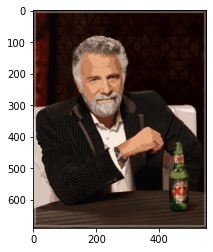

  0%|          | 0/100 [00:00<?, ?it/s]

-------------
K :  64


  1%|          | 1/100 [00:19<31:55, 19.35s/it]

Loss : 385509.4255426665


  2%|▏         | 2/100 [00:38<31:26, 19.25s/it]

Loss : 1119493.1388075491


  3%|▎         | 3/100 [00:58<31:28, 19.47s/it]

Loss : 1349762.7719917148


  4%|▍         | 4/100 [01:18<31:16, 19.54s/it]

Loss : 1491514.2930978427


  5%|▌         | 5/100 [01:39<31:47, 20.08s/it]

Loss : 1568966.283210507


  6%|▌         | 6/100 [02:01<32:29, 20.73s/it]

Loss : 1624034.6103899153


  7%|▋         | 7/100 [02:20<31:23, 20.25s/it]

Loss : 1681599.525655579


  8%|▊         | 8/100 [02:39<30:27, 19.87s/it]

Loss : 1718341.2179514002


  9%|▉         | 9/100 [02:58<29:36, 19.52s/it]

Loss : 1752130.658417603


 10%|█         | 10/100 [03:17<29:13, 19.49s/it]

Loss : 1787463.0280616924


 11%|█         | 11/100 [03:37<28:46, 19.40s/it]

Loss : 1826794.64172672


 12%|█▏        | 12/100 [03:56<28:31, 19.45s/it]

Loss : 1861680.106525342


 13%|█▎        | 13/100 [04:15<28:03, 19.35s/it]

Loss : 1891810.0818083556


 14%|█▍        | 14/100 [04:35<27:44, 19.36s/it]

Loss : 1923293.677022834


 15%|█▌        | 15/100 [04:54<27:38, 19.51s/it]

Loss : 1952092.6065028745


 16%|█▌        | 16/100 [05:14<27:07, 19.37s/it]

Loss : 1969023.582664449


 17%|█▋        | 17/100 [05:34<27:22, 19.79s/it]

Loss : 1979264.0837760256


 18%|█▊        | 18/100 [05:54<27:08, 19.85s/it]

Loss : 1987571.374076611


 19%|█▉        | 19/100 [06:15<27:02, 20.03s/it]

Loss : 1994461.89947426


 20%|██        | 20/100 [06:38<27:59, 20.99s/it]

Loss : 1999971.4275475203


 21%|██        | 21/100 [06:58<27:19, 20.75s/it]

Loss : 2004175.7931969357


 22%|██▏       | 22/100 [07:19<27:04, 20.83s/it]

Loss : 2007482.4631511897


 23%|██▎       | 23/100 [07:41<27:07, 21.14s/it]

Loss : 2010276.5331978975


 24%|██▍       | 24/100 [08:02<26:41, 21.07s/it]

Loss : 2012737.3655667184


 25%|██▌       | 25/100 [08:22<26:02, 20.84s/it]

Loss : 2014952.099488625


 26%|██▌       | 26/100 [08:42<25:19, 20.53s/it]

Loss : 2017007.0602847165


 27%|██▋       | 27/100 [09:10<27:36, 22.68s/it]

Loss : 2018974.6991269647


 28%|██▊       | 28/100 [09:35<28:08, 23.45s/it]

Loss : 2020886.1654978213


 29%|██▉       | 29/100 [10:00<28:22, 23.98s/it]

Loss : 2022742.0385276796


 30%|███       | 30/100 [10:22<27:22, 23.46s/it]

Loss : 2024538.172885561


 31%|███       | 31/100 [10:44<26:12, 22.79s/it]

Loss : 2026282.000650656


 32%|███▏      | 32/100 [11:05<25:13, 22.26s/it]

Loss : 2027985.4847781525


 33%|███▎      | 33/100 [11:25<24:20, 21.79s/it]

Loss : 2029642.8418400697


 34%|███▍      | 34/100 [11:46<23:25, 21.30s/it]

Loss : 2031241.3462912543


 35%|███▌      | 35/100 [12:06<22:49, 21.07s/it]

Loss : 2032784.1275427467


 36%|███▌      | 36/100 [12:30<23:13, 21.78s/it]

Loss : 2034283.50855652


 37%|███▋      | 37/100 [12:51<22:48, 21.73s/it]

Loss : 2035752.466391346


 38%|███▊      | 38/100 [13:15<23:01, 22.28s/it]

Loss : 2037205.7623570345


 39%|███▉      | 39/100 [13:37<22:32, 22.17s/it]

Loss : 2038660.5260905917


 40%|████      | 40/100 [13:58<22:03, 22.05s/it]

Loss : 2040134.568557542


 41%|████      | 41/100 [14:19<21:15, 21.63s/it]

Loss : 2041643.9493752334


 42%|████▏     | 42/100 [14:40<20:42, 21.42s/it]

Loss : 2043200.112061682


 43%|████▎     | 43/100 [15:01<20:07, 21.19s/it]

Loss : 2044807.994703689


 44%|████▍     | 44/100 [15:22<19:44, 21.14s/it]

Loss : 2046467.0376754561


 45%|████▌     | 45/100 [15:43<19:17, 21.05s/it]

Loss : 2048176.8484144146


 46%|████▌     | 46/100 [16:03<18:46, 20.87s/it]

Loss : 2049946.536259457


 47%|████▋     | 47/100 [16:24<18:21, 20.79s/it]

Loss : 2051805.947661228


 48%|████▊     | 48/100 [16:44<17:54, 20.66s/it]

Loss : 2053823.1345891042


 49%|████▉     | 49/100 [17:04<17:31, 20.61s/it]

Loss : 2056130.963150352


 50%|█████     | 50/100 [17:25<17:05, 20.52s/it]

Loss : 2058927.3678871884


 51%|█████     | 51/100 [17:45<16:40, 20.41s/it]

Loss : 2062329.1730471812


 52%|█████▏    | 52/100 [18:05<16:11, 20.23s/it]

Loss : 2066097.0844347705


 53%|█████▎    | 53/100 [18:24<15:41, 20.03s/it]

Loss : 2069714.6896825444


 54%|█████▍    | 54/100 [18:45<15:29, 20.21s/it]

Loss : 2072935.1993519478


 55%|█████▌    | 55/100 [19:07<15:40, 20.90s/it]

Loss : 2075954.5924411379


 56%|█████▌    | 56/100 [19:27<15:08, 20.65s/it]

Loss : 2079031.8750355907


 57%|█████▋    | 57/100 [19:47<14:34, 20.33s/it]

Loss : 2082315.158206511


 58%|█████▊    | 58/100 [20:10<14:43, 21.03s/it]

Loss : 2085861.4646648113


 59%|█████▉    | 59/100 [20:30<14:12, 20.79s/it]

Loss : 2089632.334417747


 60%|██████    | 60/100 [20:51<13:49, 20.74s/it]

Loss : 2093473.2437566791


 61%|██████    | 61/100 [21:14<14:00, 21.55s/it]

Loss : 2097150.1070436998


 62%|██████▏   | 62/100 [21:37<13:59, 22.10s/it]

Loss : 2100441.564496114


 63%|██████▎   | 63/100 [22:00<13:44, 22.28s/it]

Loss : 2103239.7868056013


 64%|██████▍   | 64/100 [22:22<13:20, 22.23s/it]

Loss : 2105571.177798413


 65%|██████▌   | 65/100 [22:44<12:49, 21.99s/it]

Loss : 2107522.643749697


 66%|██████▌   | 66/100 [23:07<12:38, 22.30s/it]

Loss : 2109177.2188213742


 67%|██████▋   | 67/100 [23:27<11:54, 21.65s/it]

Loss : 2110601.2044120235


 68%|██████▊   | 68/100 [23:48<11:32, 21.63s/it]

Loss : 2111851.811246563


 69%|██████▉   | 69/100 [24:09<11:00, 21.30s/it]

Loss : 2112981.22579317


 70%|███████   | 70/100 [24:28<10:22, 20.73s/it]

Loss : 2114038.043732796


 71%|███████   | 71/100 [24:48<09:51, 20.40s/it]

Loss : 2115070.762196559


 72%|███████▏  | 72/100 [25:07<09:20, 20.03s/it]

Loss : 2116132.9227725277


 73%|███████▎  | 73/100 [25:27<08:55, 19.84s/it]

Loss : 2117285.396370868


 74%|███████▍  | 74/100 [25:46<08:34, 19.78s/it]

Loss : 2118585.8920499454


 75%|███████▌  | 75/100 [26:06<08:13, 19.75s/it]

Loss : 2120055.3900025664


 76%|███████▌  | 76/100 [26:25<07:49, 19.57s/it]

Loss : 2121643.5145768886


 77%|███████▋  | 77/100 [26:44<07:29, 19.55s/it]

Loss : 2123246.7866023015


 78%|███████▊  | 78/100 [27:04<07:07, 19.45s/it]

Loss : 2124778.7986984598


 79%|███████▉  | 79/100 [27:23<06:50, 19.54s/it]

Loss : 2126217.200933707


 80%|████████  | 80/100 [27:43<06:31, 19.58s/it]

Loss : 2127591.352443138


 81%|████████  | 81/100 [28:03<06:11, 19.55s/it]

Loss : 2128947.5167385465


 82%|████████▏ | 82/100 [28:23<05:55, 19.75s/it]

Loss : 2130297.1154023563


 83%|████████▎ | 83/100 [28:43<05:35, 19.75s/it]

Loss : 2131598.588824005


 84%|████████▍ | 84/100 [29:02<05:14, 19.65s/it]

Loss : 2132813.592743341


 85%|████████▌ | 85/100 [29:22<04:56, 19.74s/it]

Loss : 2133945.488964769


 86%|████████▌ | 86/100 [29:42<04:37, 19.81s/it]

Loss : 2135002.815737205


 87%|████████▋ | 87/100 [30:02<04:17, 19.82s/it]

Loss : 2135997.441672081


 88%|████████▊ | 88/100 [30:21<03:56, 19.73s/it]

Loss : 2136940.2753770384


 89%|████████▉ | 89/100 [30:40<03:35, 19.55s/it]

Loss : 2137839.0009078467


 90%|█████████ | 90/100 [31:00<03:15, 19.51s/it]

Loss : 2138700.345221464


 91%|█████████ | 91/100 [31:19<02:55, 19.45s/it]

Loss : 2139529.7125160624


 92%|█████████▏| 92/100 [31:39<02:35, 19.47s/it]

Loss : 2140330.7628741586


 93%|█████████▎| 93/100 [31:58<02:16, 19.51s/it]

Loss : 2141105.9958404102


 94%|█████████▍| 94/100 [32:18<01:57, 19.59s/it]

Loss : 2141858.133129448


 95%|█████████▌| 95/100 [32:38<01:38, 19.63s/it]

Loss : 2142590.8864220474


 96%|█████████▌| 96/100 [32:57<01:18, 19.60s/it]

Loss : 2143308.1042496534


 97%|█████████▋| 97/100 [33:17<00:59, 19.70s/it]

Loss : 2144011.4409885486


 98%|█████████▊| 98/100 [33:37<00:39, 19.65s/it]

Loss : 2144697.1581437616


 99%|█████████▉| 99/100 [33:56<00:19, 19.62s/it]

Loss : 2145354.4822966736


100%|██████████| 100/100 [34:16<00:00, 20.57s/it]

Loss : 2145969.7079240177
All the iterations have been completed


64 : The error is : 0.0009087856060250237


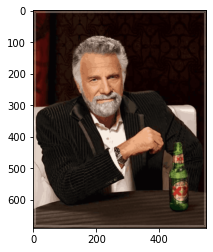

-------------


In [19]:
K = [1, 2, 4, 8 , 16 , 32 , 64]

for k in K:
    print("K : % 2d" %(k))
    fit(k, X=data)
    print('-------------')